#Predicting NBA games using seasonal and team data

# Who will win? The answer is more valuable than ever before.

On May 4, 2018, the United States Supreme Court voted to legalize sports gambling nationwide,  immediately setting off a boom in the market. In the next two years, 20 billion dollars would be bet in United States sportsbooks[1]. Catalyzed by the deregulation of the practice in the US, the global sports gambling market is now estimated to represent 70% of all gambling worldwide, and is estimated to be worth over 155 billion dollars by 2024[2]. 

However, attaining success gambling on sports like basketball, and consistently predicting the winners of NBA games is a non-trivial task. The growing parity of the league and uncertainty about seasonal outcomes are major contributing factors to this. We were motivated by a key question: is it possible to predict the winner of an NBA game based on teams’ historical performances? Given that an NBA team’s year-over-year performance remains relatively static compared with NFL or MLB teams[3], we wanted to determine the extent to which one can accurately predict the winner of an NBA game based on how the two competing teams performed in the previous season. Through the use of machine learning methods, we hope to analyze the extent to which both fans and sports can better utilize publicly-available team statistics to accurately forecast the outcome of NBA games.

For our analysis, we will build a machine learning model which predicts the winner of an NBA game based on each team's statistic characteristics from the previous season. For example, for a 2020 game between the Los Angeles Lakers and Miami Heat, the model would examine the total number of points, rebounds, assists (among other features) that the Lakers and Heat produced in 2019 (the previous year), and use those statistics to predict the winner of the current year's game. 

Finally, we will evaluate the machine learning model we build by comparing its predictions of 2019-2020 NBA game winners to the actual winners from the season. 

# Data Extraction and Wrangling

To begin our analysis, we need data. Specifically, we would like to look at the results from NBA games dating back to 2005 (the first season of the "modern" NBA era of 30 teams). Additionally, we need the the descriptive statistics of each team dating back to that period. 

The NBA stores a plethora of statistics on their official, public stats database (stats.nba.com). However, instead of directly scraping statistics from the NBA website, we will utilize an open-source API that interfaces with the NBA's website and allows us to extract data directly into Pandas DataFrames[4].

First, we must install the NBA API, as well as Pandas and Numpy for wrangling and cleaning the data in the future.

In [ ]:
# # install NBA API module and Pandas
!pip3 install nba_api
!pip3 install requests
!pip3 install pandas
!pip3 install numpy

In [ ]:
# import necessary modules
import numpy as np
import pandas as pd
import time as time
import os
# from the NBA API, import the modeules needed to extract seasonal game data and team statistics
from nba_api.stats.endpoints import teamyearbyyearstats as teamstats, teamgamelogs as games, teamdashboardbylastngames as lastn

**Regarding the use of the NBA API**

The steps utilizing the NBA API require disconnecting the Colab notebook from Google's servers and connect the notebook to a local runtime. For instructions on how to do this, see https://research.google.com/colaboratory/local-runtimes.html.

## Season Data
Now, we need to extract seasonal game data dating back to the 2005-2006 season. First, though, let's take a moment to look at the raw data provided by the NBA for a single season.

In [ ]:
# fetch game data and convert to Pandas DataFrame
gameData = games.TeamGameLogs(season_nullable="2018-19")
gameData = gameData.get_data_frames()[0]
gameData.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,2018-19,1610612760,OKC,Oklahoma City Thunder,0021801226,2019-04-10T00:00:00,OKC @ MIL,W,48.0,48,...,267,5,890,1203,1731,42,940,2311,249,493
1,2018-19,1610612748,MIA,Miami Heat,0021801221,2019-04-10T00:00:00,MIA @ BKN,L,48.0,38,...,211,1558,1390,615,1329,393,23,2382,2235,2211
2,2018-19,1610612755,PHI,Philadelphia 76ers,0021801224,2019-04-10T00:00:00,PHI vs. CHI,W,48.0,52,...,893,308,35,2133,53,393,11,2382,315,303
3,2018-19,1610612766,CHA,Charlotte Hornets,0021801222,2019-04-10T00:00:00,CHA vs. ORL,L,48.0,41,...,2400,1752,96,2301,1329,146,80,1522,959,1711
4,2018-19,1610612759,SAS,San Antonio Spurs,0021801227,2019-04-10T00:00:00,SAS vs. DAL,W,48.0,41,...,267,1558,444,1543,2069,731,80,1522,1659,493


There are some noteworthy characteristics about the format and features of the NBA's seasonal data. 

The first observation is that for each game, the DataFrame contains two rows: one corresponding to each team in the game. Each of these rows for a gam contains information about how a team performed in that particular game. For example, a game between PHI and CHI contains two rows in the DataFrame. One row contains the statistics for PHI for that particular game, while the second row contains statistics for CHI for that game.

However, for our model, we do not care about how teams performed statistically in a particular game; we only care about which team was the home team, which team was the away team, and which team won. To classify the home and away teams for a game, we therefore need to parse the "MATCHUP" column from the DataFrame and extract information about the home and away teams. Thus, we must apply the following transformations to the data: 

```
# add columns for home and away teams
  gameData['HOME_TEAM'] = gameData['MATCHUP'].apply(lambda x: x[-3:] if x[4] == '@' else x[:3])
  gameData['AWAY_TEAM'] = gameData['MATCHUP'].apply(lambda x: x[:3] if x[4] == '@' else x[-3:])
  ```



Additionally, after creating columns to identify the home and away teams, we need to record the winner of the game. To record the winner, we will create a one-hot encoding for which "1" represents the winner, and "0" represents the loser of a game. Since we can infer whether the away team won or lost based on whether the home team won or lost, we can just create a one-hot encoding function for the home team and assign the away team value based on the opposite encoding of the home team. Thus, we need to apply the following function to the DataFrame:



```
def HomeTeamWon(x):
  teamAbbreviation = x['TEAM_ABBREVIATION']
  homeTeam = x['HOME_TEAM']
  awayTeam = x['AWAY_TEAM']
  WL = x['WL']
  if teamAbbreviation == homeTeam:
    if WL == "L":
      return 0
    elif WL == "W":
      return 1
  else:
    if WL == "L":
      return 1
    elif WL == "W":
      return 0

  # add one-hot encoding for game winners
  gameData['HOME_TEAM_WIN'] = gameData.apply(HomeTeamWon, axis=1)
  gameData['AWAY_TEAM_WIN'] = gameData['HOME_TEAM_WIN'].apply(lambda x: 0 if x == 1 else 1)
```





All the aforementioned transformations are applied below. In the end, we will save our wrangled DataFrames as CSV files to use them in future cleaning.

In [ ]:
def HomeTeamWon(x):
  teamAbbreviation = x['TEAM_ABBREVIATION']
  homeTeam = x['HOME_TEAM']
  awayTeam = x['AWAY_TEAM']
  WL = x['WL']
  if teamAbbreviation == homeTeam:
    if WL == "L":
      return 0
    elif WL == "W":
      return 1
  else:
    if WL == "L":
      return 1
    elif WL == "W":
      return 0

In [ ]:
# create a list to store the seasons from which we need to extract data
years = ["2005-06","2006-07","2007-08","2008-09","2009-10","2010-11","2011-12","2012-13","2013-14","2014-15","2015-16","2016-17","2017-18","2018-19", "2019-20"]
# iterate through the list of years
for year in years:
  # implement manual timeout to avoid API throttling
  time.sleep(5)
  # fetch game data and convert to Pandas DataFrame
  gameData = games.TeamGameLogs(season_nullable=year)
  gameData = gameData.get_data_frames()[0]
  # fix object types such that the types are in a more queryable format for analysis
  gameData['SEASON_YEAR'] = gameData['SEASON_YEAR'].astype('|S')
  gameData['SEASON_YEAR'] = gameData['SEASON_YEAR'].str.decode('utf-8')
  gameData['TEAM_ABBREVIATION'] = gameData['TEAM_ABBREVIATION'].astype('|S')
  gameData['TEAM_ABBREVIATION'] = gameData['TEAM_ABBREVIATION'].str.decode('utf-8')
  gameData['TEAM_NAME'] = gameData['TEAM_NAME'].astype('|S')
  gameData['TEAM_NAME'] = gameData['TEAM_NAME'].str.decode('utf-8')
  gameData['GAME_ID'] = gameData['GAME_ID'].astype('|S')
  gameData['GAME_ID'] = gameData['GAME_ID'].str.decode('utf-8')
  gameData['SEASON_YEAR'] = gameData['SEASON_YEAR'].astype('|S')
  gameData['SEASON_YEAR'] = gameData['SEASON_YEAR'].str.decode('utf-8')
  gameData['MATCHUP'] = gameData['MATCHUP'].astype('|S')
  gameData['MATCHUP'] = gameData['MATCHUP'].str.decode('utf-8')
  gameData['WL'] = gameData['WL'].astype('|S')
  gameData['WL'] = gameData['WL'].str.decode('utf-8')
  gameData['GAME_DATE'] = pd.to_datetime(gameData['GAME_DATE'].str.strip())
  # add columns for home and away teams
  gameData['HOME_TEAM'] = gameData['MATCHUP'].apply(lambda x: x[-3:] if x[4] == '@' else x[:3])
  gameData['AWAY_TEAM'] = gameData['MATCHUP'].apply(lambda x: x[:3] if x[4] == '@' else x[-3:])
  # add one-hot encoding for game winners
  gameData['HOME_TEAM_WIN'] = gameData.apply(HomeTeamWon, axis=1)
  gameData['AWAY_TEAM_WIN'] = gameData['HOME_TEAM_WIN'].apply(lambda x: 0 if x == 1 else 1)
  # download DataFrame as csv
  gameData.to_csv(r'/Users/kirancherukuri/Desktop/seasonData'+year+'.csv', index = False, header=True)

## Team Data

Since the model will be trained on game data from the 2005-2006 season through the 2018-2019 season, we need to extract team data starting from the 2004-2005 season (since the model will utilize teams' previous season (t-1) statistics to predict their performance in the next season (t). First, let's take a look at what the team statistics look like for a team.

In [ ]:
# fetch team data from NBA
team = teamstats.TeamYearByYearStats(team_id=str(1610612738))
# convert raw data to Pandas DataFrame
team = team.get_data_frames()[0]
team

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612738,Boston,Celtics,1946-47,60,22,38,0.367,0,5,...,0,0,0,470,1202,0,0,0,3605,11
1,1610612738,Boston,Celtics,1947-48,48,20,28,0.417,0,3,...,0,0,0,364,1065,0,0,0,3303,8
2,1610612738,Boston,Celtics,1948-49,60,25,35,0.417,0,5,...,0,0,0,1135,1382,0,0,0,4593,9
3,1610612738,Boston,Celtics,1949-50,68,22,46,0.324,0,6,...,0,0,0,1473,1644,0,0,0,5420,7
4,1610612738,Boston,Celtics,1950-51,69,39,30,0.565,0,2,...,0,0,0,1579,1881,0,0,0,5881,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1610612738,Boston,Celtics,2015-16,82,48,34,0.585,5,2,...,950,2733,3683,1981,1796,752,1127,348,8669,5
70,1610612738,Boston,Celtics,2016-17,82,53,29,0.646,1,1,...,743,2698,3441,2069,1686,617,1088,340,8857,7
71,1610612738,Boston,Celtics,2017-18,82,55,27,0.671,2,2,...,767,2878,3645,1842,1618,604,1148,373,8529,20
72,1610612738,Boston,Celtics,2018-19,82,49,33,0.598,4,3,...,804,2849,3653,2155,1670,706,1052,435,9216,14


As we can see, the NBA provides team statistics for a team for every year of the team's franchise history. Since we want to extract a team's statistics for a single year at a time, we must select individual rows from each team's DataFrame for a given year and concatenate these individual rows. In the end, we will have a DataFrame for each year, in which each row corresponds to a team's performative statistics for that year. Again, we will save our wrangled DataFrames as CSV files to use them in future cleaning.

In [ ]:
# create a list of all the team ID's of each NBA team, according to the API documentation (for seasons 2004-05 - 2018-19)
teamids = [1610612737,1610612738,1610612751,1610612766,1610612741,1610612739,1610612742,1610612743,1610612765,1610612744,1610612745,1610612754,1610612746,1610612747,1610612763,1610612748,1610612749,1610612750,1610612740,1610612752,1610612760,1610612753,1610612755,1610612756,1610612757,1610612758,1610612759,1610612761,1610612762,1610612764]
# create indices corresponding to each year from which we want to extract data
years = [i for i in range(-16, -1)]
yearDict = {-16: "2004-05", -15: "2005-06", -14: "2006-07", -13: "2007-08", -12: "2008-09", -11: "2009-10", -10: "2010-11", -9: "2011-12", -8: "2012-13", -7: "2013-14", -6: "2014-15", -5: "2015-16", -4: "2016-17", -3: "2017-18", -2: "2018-19"}
# iterate through each year
for year in years:
  # create initial empty DataFrame to store all team data for a particular season
  teamData = pd.DataFrame()
  # iterate through all teams using team ID's and extract team stats for the 2018-2019 season
  for id in teamids:
    # fetch team data from NBA
    team = teamstats.TeamYearByYearStats(team_id=str(id))
    # convert raw data to Pandas DataFrame
    team = team.get_data_frames()[0]
    # select corresponding season data from the DataFrame which contains 
    team = team.iloc[[year]]
    # reset index
    team.reset_index(drop=True, inplace=True)
    # add the data for a team to the comprehensive list of team data for the season
    teamData = pd.concat([teamData, team], ignore_index=True)
    # implement a manual timeout of the API calls to prevent throttling
    time.sleep(2)
  # since some of the raw datatypes from the API response are objects, we want to convert them to datatypes more appropriate for querying and analysis
  teamData['TEAM_CITY'] = teamData['TEAM_CITY'].astype('|S')
  teamData['TEAM_CITY'] = teamData['TEAM_CITY'].str.decode('utf-8')
  teamData['TEAM_NAME'] = teamData['TEAM_NAME'].astype('|S')
  teamData['TEAM_NAME'] = teamData['TEAM_NAME'].str.decode('utf-8')
  teamData['YEAR'] = teamData['YEAR'].astype('|S')
  teamData['YEAR'] = teamData['YEAR'].str.decode('utf-8')
  teamData['NBA_FINALS_APPEARANCE'] = teamData['NBA_FINALS_APPEARANCE'].astype('|S')
  teamData['NBA_FINALS_APPEARANCE'] = teamData['NBA_FINALS_APPEARANCE'].str.decode('utf-8')
  # download teamData DataFrames for each season as csv files to store and access for future use
  teamData.to_csv(r'/Users/kirancherukuri/Desktop/teamData' + yearDict[year] + '.csv', index = False, header=True)

# Data Cleaning

Now that we have the season and team datasets of interest, we need to clean them in preparation of performing exploratory data analysis and eventual construction of our machine learning model.

For posterity, we will use the datasets as saved in CSV files in the previous section.

**NOTE: the csv files can be accessed using the Drive folder below**
https://drive.google.com/drive/folders/1Ifk-DSWGHuDhHmnMPEOroT6JcnVrwGco?usp=sharing

In [ ]:
# import csv files of the season and team data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files_source_team = '/content/drive/MyDrive/545Project/Data/Team Data/'
files_source_season = '/content/drive/MyDrive/545Project/Data/Season Data/'
# initialize list to store all team data csv files
teamList = []
for filenames in os.walk(files_source_team):
    teamList.append(filenames)

# initialize list to store all season data csv files
seasonList = []
for filenames in os.walk(files_source_season):
    seasonList.append(filenames)

# fix indices of team and season lists
teamList = teamList[0][2]
seasonList = seasonList[0][2]

In [ ]:
# initialize list to store all season DataFrames
seasonDfs = []
for file in seasonList:
    df = pd.read_csv(files_source_season + file)
    seasonDfs.append(df)

# initialize list to store all team DataFrames
teamDfs = []
for file in teamList:
    df = pd.read_csv(files_source_team + file)
    teamDfs.append(df)

Now that we have all the season and team data stored in an array of DataFrames, we can further examine and clean the data. First, let's take a look a sample of the team data we have by examinining the team DataFrame from the 2017-18 season.

In [ ]:
# look at a sample of team data for a single season
teamDfs[-2].head()

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,CONF_COUNT,DIV_COUNT,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612737,Atlanta,Hawks,2017-18,82,24,58,0.293,15,5,0,0,15.0,5,NaN,3130,7015,0.446,917,2544,0.360,1298,1654,0.785,743,2693,3436,1946,1606,638,1274,348,8475,25
1,1610612738,Boston,Celtics,2017-18,82,55,27,0.671,2,2,11,8,15.0,5,NaN,3141,6975,0.450,939,2492,0.377,1308,1697,0.771,767,2878,3645,1842,1618,604,1148,373,8529,20
2,1610612751,Brooklyn,Nets,2017-18,82,28,54,0.341,12,5,0,0,15.0,5,NaN,3136,7114,0.441,1041,2924,0.356,1428,1850,0.772,792,2852,3644,1941,1688,512,1245,390,8741,14
3,1610612766,Charlotte,Hornets,2017-18,82,36,46,0.439,10,3,0,0,15.0,5,NaN,3197,7106,0.450,824,2233,0.369,1656,2216,0.747,827,2901,3728,1770,1409,559,1041,373,8874,10
4,1610612741,Chicago,Bulls,2017-18,82,27,55,0.329,13,5,0,0,15.0,5,NaN,3170,7285,0.435,906,2549,0.355,1194,1574,0.759,790,2872,3662,1923,1571,626,1147,289,8440,26


For our machine learning model, many of the current features are unnecessary. Since our model will focus on performative measures of a team from a season, we would like to remove all the non-quantitative features of a team, as well as information that offers no discriminative insight into a team's performance (for example, how many total games a team played or how many other teams are in the same conference, since these values are static across all teams). Additionally, we since we are predicting regular season games, we will remove information relating to teams' playoff performances. Thus, we will remove unwanted features from each DataFrame.

In [ ]:
cleanedTeamDfs = []
for teamDf in teamDfs:
  teamDf = teamDf[['TEAM_ID', 'WINS', 'LOSSES', 'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'FGM', 'FGA', 'FG_PCT', 'FG3A','FG3M', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV', 'BLK', 'PTS']]
  cleanedTeamDfs.append(teamDf)

Now, each DataFrame for team data in a given season contains quantitative features that can be further analyzed. 

In [ ]:
# look at a sample of cleaned team data for a single season
cleanedTeamDfs[-1].head()

,TEAM_ID,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,FGM,FGA,FG_PCT,FG3A,FG3M,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS
0,1610612737,29,53,0.354,12,5,3392,7524,0.451,3034,1067,0.352,1443,1918,0.752,955,2825,3780,2118,1932,675,1397,419,9294
1,1610612738,49,33,0.598,4,3,3451,7423,0.465,2829,1032,0.365,1282,1598,0.802,804,2849,3653,2155,1670,706,1052,435,9216
2,1610612751,42,40,0.512,6,4,3301,7358,0.449,2965,1047,0.353,1555,2088,0.745,900,2919,3819,1954,1763,539,1236,339,9204
3,1610612766,39,43,0.476,9,2,3297,7362,0.448,2783,977,0.351,1510,1895,0.797,814,2778,3592,1905,1550,591,1001,405,9081
4,1610612741,22,60,0.268,13,4,3266,7205,0.453,2123,745,0.351,1328,1695,0.783,718,2799,3517,1796,1663,603,1159,351,8605


Finally, since the list of cleaned team DataFrames contains the team data for the 2018-19 season, and we'd like to hold out that data to test our final model, we will remove it from the list. 

In [ ]:
# store final team DataFrame separately for final testing
testTeamDf = cleanedTeamDfs[-1]
cleanedTeamDfs = cleanedTeamDfs[:-1]

Next, we need to clean our season data. Let's take a look at a sample of seasonal game data for the 2018-19 season. 

In [ ]:
# look at a sample of season data for a single season
seasonDfs[-2].head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,HOME_TEAM,AWAY_TEAM,HOME_TEAM_WIN,AWAY_TEAM_WIN
0,2018-19,1610612760,OKC,Oklahoma City Thunder,21801226,2019-04-10,OKC @ MIL,W,48.0,48,99,0.485,23,54,0.426,8,13,0.615,9,44,53,40,13.0,7,3,1,20,14,127,11.0,1,1,1,1,135,201,189,762,8,15,478,2329,2234,2274,1362,110,267,5,890,1203,1731,42,940,2311,249,493,MIL,OKC,0,1
1,2018-19,1610612748,MIA,Miami Heat,21801221,2019-04-10,MIA @ BKN,L,48.0,38,98,0.388,8,41,0.195,10,15,0.667,8,46,54,22,15.0,9,4,3,12,13,94,-19.0,1,1231,1231,1231,135,1678,232,2266,1907,237,2380,2177,2083,2021,1623,43,211,1558,1390,615,1329,393,23,2382,2235,2211,BKN,MIA,1,0
2,2018-19,1610612755,PHI,Philadelphia 76ers,21801224,2019-04-10,PHI vs. CHI,W,48.0,52,93,0.559,12,26,0.462,9,15,0.600,9,38,47,30,7.0,4,10,3,11,13,125,16.0,1,1,1,1,135,53,626,94,864,1883,267,2271,2083,2311,1362,610,893,308,35,2133,53,393,11,2382,315,303,PHI,CHI,1,0
3,2018-19,1610612766,CHA,Charlotte Hornets,21801222,2019-04-10,CHA vs. ORL,L,48.0,41,78,0.526,8,29,0.276,24,27,0.889,4,28,32,21,8.0,3,4,2,14,19,114,-8.0,1,1231,1231,1231,135,1130,2303,300,1907,1510,2022,331,661,257,2360,2150,2400,1752,96,2301,1329,146,80,1522,959,1711,CHA,ORL,0,1
4,2018-19,1610612759,SAS,San Antonio Spurs,21801227,2019-04-10,SAS vs. DAL,W,48.0,41,88,0.466,8,24,0.333,15,18,0.833,8,45,53,22,11.0,6,2,4,14,19,105,11.0,1,1,1,1,135,1130,1301,1120,1907,2090,1396,1513,1774,633,1623,75,267,1558,444,1543,2069,731,80,1522,1659,493,SAS,DAL,1,0


There are quite a few steps needed to clean this data. For our machine learning model, we only wish to focus on the home team, away team, and winner for a single game. Thus, we can drop the majority of columns in each row. 

Additionally, since each game corresponds to two rows in the DataFrame, we need to remove duplicate rows which represent the same game. Because each game is assigned a unique game ID, we can look for duplicates based on this ID. Ideally, for each game, we would like to end up with a single row containing information about which team was home, which team was away, and which team won the game. 



In [ ]:
# initialize a list for storing the cleaned season DataFrames
cleanedSeasonDfs = []
# iterate through each season DataFrame in the current list of season DataFrames
for seasonDf in seasonDfs:
    # initialize a list for storing unique game ids
    gameids = []
    # initialize a new dataframe to store only the columns of interest for each row
    cleanedSeasonDf = pd.DataFrame()
    # iterate through rows in season DataFrame
    for index, row in seasonDf.iterrows():
    # append unique game ids to list of gameids
        if row["GAME_ID"] not in gameids:
            gameids.append(row['GAME_ID'])
    # now that we have a list of unique game ids, iterate through and extract information for home and away teams
    for gameid in gameids:
        # create a mini dataframe for each game, where each of the two rows corresponds to a team in the matchup, by filtering the season dataframe to only the rows corresponding to the game id
        gameTeams = seasonDf[seasonDf['GAME_ID'] == gameid]
        gameTeams.reset_index(inplace=True, drop=True)
        # iterate through the 2 rows in the mini game dataframe
        for index, row in gameTeams.iterrows():
            # check if the team abbreviation for a row is corresponding to the home or away team
            if row['HOME_TEAM'] == row['TEAM_ABBREVIATION']:
              # store the home team ID in a variable
              homeTeamId = row['TEAM_ID']
            else:
              # store the away team ID in a variable
              awayTeamId = row['TEAM_ID']
        # store the home team name in a variable
        homeTeam = gameTeams.iloc[[0]]['HOME_TEAM']
        # store the away team name in a variable
        awayTeam = gameTeams.iloc[[0]]['AWAY_TEAM']
        # store the one-hot encoding for whether the home team won or lost in a variable
        homeTeamWin = gameTeams.iloc[[0]]['HOME_TEAM_WIN']
        # store the one-hot encoding for whether the away team won or lost in a variable
        awayTeamWin = gameTeams.iloc[[0]]['AWAY_TEAM_WIN']

        # create a new DataFrame row with all the relevant columns
        gameTeams = pd.DataFrame({'HOME_TEAM': homeTeam, 'AWAY_TEAM': awayTeam, 'HOME_TEAM_ID': homeTeamId, 'AWAY_TEAM_ID': awayTeamId, 'HOME_TEAM_WIN': homeTeamWin, 'AWAY_TEAM_WIN': awayTeamWin})
        # add the game row to the new, cleaned season dataframe
        cleanedSeasonDf = pd.concat([cleanedSeasonDf, gameTeams])
    # append the cleaned DataFrame for a season to the list of cleaned season DataFrames
    cleanedSeasonDfs.append(cleanedSeasonDf)

Now, each season DataFrame contains the necessary features required to merge with team data and be input into our machine learning model.

In [ ]:
# look at a sample of cleaned season data for a single season
cleanedSeasonDfs[-2].head()

,HOME_TEAM,AWAY_TEAM,HOME_TEAM_ID,AWAY_TEAM_ID,HOME_TEAM_WIN,AWAY_TEAM_WIN
0,MIL,OKC,1610612749,1610612760,0,1
0,BKN,MIA,1610612751,1610612748,1,0
0,PHI,CHI,1610612755,1610612741,1,0
0,CHA,ORL,1610612766,1610612753,0,1
0,SAS,DAL,1610612759,1610612742,1,0


Finally, since the list of cleaned season DataFrames contains the season data for the 2019-20 season, and we'd like to hold out that data to test our final model, we will remove it from the list. 

In [ ]:
# store final season DataFrame separately for final testing
testSeasonDf = cleanedSeasonDfs[-1]
cleanedSeasonDfs = cleanedSeasonDfs[:-1]

At this point, the season and team datasets have been cleaned. Now, we must merge the two datasets. For each game, in addition knowing the winner and loser, we need to add the statistics for each of the teams. Thus, the next step requires joining the season data with the team data based on the IDs of the home team and away team for each game. In the end, each row should have information about the winner of a game in a particular season t, as well as the statistics from the previous season t-1 for both teams. 

For example, a row corresponding to game between home team MIL and away team OKC in the 2017-18 season should indicate the winner of the game as well as the overall statistics for the two teams from the 2016-17 season. 

In applying this join, we will end up with a final dataset containing labels (whether a team won or lost) and features (the teams' statistics going into a game) primed for training a machine learning model. 

However, since we want a single row to hold information for both teams, we will not implement a traditional join. Instead, we will implement a modified join method to match team data to season data based on team IDs.

In [ ]:
# creating a merged DataFrame
mergedSeasonDfs = pd.DataFrame()
# iterate through season DataFrames
for i in range(len(cleanedSeasonDfs)):
  mergedSeasonDf = pd.DataFrame()
  # iterate through each row (each game)
  for index, row in cleanedSeasonDfs[i].iterrows():
    # store whether or not the home team won in a variable
    team1Win = row['HOME_TEAM_WIN']
    # store information for the IDs of the home and away teams
    team1Id = row['HOME_TEAM_ID']
    team2Id = row['AWAY_TEAM_ID']
    # reference teams DataFrame for the previous season
    teamDf = teamDfs[i]
    # record team 1's statistics
    team1stats = teamDf[teamDf['TEAM_ID'] == team1Id]
    team1stats = team1stats.to_dict('records')
    team1stats = team1stats[0]
    team1WINS = team1stats['WINS']
    team1LOSSES = team1stats['LOSSES']
    team1WIN_PCT = team1stats['WIN_PCT']
    team1CONF_RANK = team1stats['CONF_RANK']
    team1DIV_RANK = team1stats['DIV_RANK']
    team1AST = team1stats['AST']
    team1BLK = team1stats['BLK']
    team1DREB = team1stats['DREB']
    team1FG3A = team1stats['FG3A']
    team1FG3M = team1stats['FG3M']
    team1FG3_PCT = team1stats['FG3_PCT']
    team1FGA = team1stats['FGA']
    team1FGM = team1stats['FGM']
    team1FG_PCT = team1stats['FG_PCT']
    team1FTA = team1stats['FTA']
    team1FTM = team1stats['FTM']
    team1FT_PCT = team1stats['FT_PCT']
    team1OREB = team1stats['OREB']
    team1PF = team1stats['PF']
    team1PTS = team1stats['PTS']
    team1REB = team1stats['REB']
    team1STL = team1stats['STL']
    team1TOV = team1stats['TOV']
    # record team 2's statistics
    team2stats = teamDf[teamDf['TEAM_ID'] == team2Id]
    team2stats = team2stats.to_dict('records')
    team2stats = team2stats[0]
    team2WINS = team2stats['WINS']
    team2LOSSES = team2stats['LOSSES']
    team2WIN_PCT = team2stats['WIN_PCT']
    team2CONF_RANK = team2stats['CONF_RANK']
    team2DIV_RANK = team2stats['DIV_RANK']
    team2AST = team2stats['AST']
    team2BLK = team2stats['BLK']
    team2DREB = team2stats['DREB']
    team2FG3A = team2stats['FG3A']
    team2FG3M = team2stats['FG3M']
    team2FG3_PCT = team2stats['FG3_PCT']
    team2FGA = team2stats['FGA']
    team2FGM = team2stats['FGM']
    team2FG_PCT = team2stats['FG_PCT']
    team2FTA = team2stats['FTA']
    team2FTM = team2stats['FTM']
    team2FT_PCT = team2stats['FT_PCT']
    team2OREB = team2stats['OREB']
    team2PF = team2stats['PF']
    team2PTS = team2stats['PTS']
    team2REB = team2stats['REB']
    team2STL = team2stats['STL']
    team2TOV = team2stats['TOV']
    # create a row for overall game stats
    gameStats = pd.DataFrame({'team1Win': team1Win, 'team1WINS': team1WINS,'team1LOSSES': team1LOSSES,'team1WIN_PCT': team1WIN_PCT,'team1CONF_RANK': team1CONF_RANK,'team1DIV_RANK': team1DIV_RANK,'team1AST': team1AST, 'team1BLK': team1BLK, 'team1DREB': team1DREB, 'team1FG3A': team1FG3A, 'team1FG3M': team1FG3M, 'team1FG3_PCT': team1FG3_PCT, 'team1FGA': team1FGA, 'team1FGM': team1FGM, 'team1FG_PCT': team1FG_PCT, 'team1FTA': team1FTA, 'team1FTM': team1FTM, 'team1FT_PCT': team1FT_PCT, 'team1OREB': team1OREB, 'team1PF': team1PF, 'team1PTS': team1PTS, 'team1REB': team1REB, 'team1STL': team1STL, 'team1TOV': team1TOV, 'team2WINS': team2WINS,'team2LOSSES': team2LOSSES,'team2WIN_PCT': team2WIN_PCT,'team2CONF_RANK': team2CONF_RANK,'team2DIV_RANK': team2DIV_RANK,'team2AST': team2AST, 'team2BLK': team2BLK, 'team2DREB': team2DREB, 'team2FG3A': team2FG3A, 'team2FG3M': team2FG3M, 'team2FG3_PCT': team2FG3_PCT, 'team2FGA': team2FGA, 'team2FGM': team2FGM, 'team2FG_PCT': team2FG_PCT, 'team2FTA': team2FTA, 'team2FTM': team2FTM, 'team2FT_PCT': team2FT_PCT, 'team2OREB': team2OREB, 'team2PF': team2PF, 'team2PTS': team2PTS, 'team2REB': team2REB, 'team2STL': team2STL, 'team2TOV': team2TOV}, index=[0])
    mergedSeasonDf = pd.concat([mergedSeasonDf, gameStats])
  mergedSeasonDfs = pd.concat([mergedSeasonDfs, mergedSeasonDf])

Let's take a look at our final merged dataset.

In [ ]:
mergedSeasonDfs

,team1Win,team1WINS,team1LOSSES,team1WIN_PCT,team1CONF_RANK,team1DIV_RANK,team1AST,team1BLK,team1DREB,team1FG3A,team1FG3M,team1FG3_PCT,team1FGA,team1FGM,team1FG_PCT,team1FTA,team1FTM,team1FT_PCT,team1OREB,team1PF,team1PTS,team1REB,team1STL,team1TOV,team2WINS,team2LOSSES,team2WIN_PCT,team2CONF_RANK,team2DIV_RANK,team2AST,team2BLK,team2DREB,team2FG3A,team2FG3M,team2FG3_PCT,team2FGA,team2FGM,team2FG_PCT,team2FTA,team2FTM,team2FT_PCT,team2OREB,team2PF,team2PTS,team2REB,team2STL,team2TOV
0,0,54,28,0.659,2,1,1787,497,2507,1053,363,0.345,6421,2851,0.444,2150,1588,0.739,1054,1638,7653,3561,576,1133,45,37,0.549,5,2,1563,347,2374,1498,514,0.343,6794,2966,0.437,2476,1795,0.725,1133,1807,8241,3507,716,1172
0,1,45,37,0.549,4,1,1810,423,2438,1252,437,0.349,6511,3046,0.468,2323,1775,0.764,909,2000,8304,3347,667,1297,59,23,0.720,1,1,1790,474,2639,1260,475,0.377,6368,3097,0.486,2466,1658,0.672,887,1814,8327,3526,528,1127
0,0,42,40,0.512,8,3,1772,308,2387,1203,435,0.362,6419,2753,0.429,2039,1555,0.763,855,1985,7496,3242,650,1164,33,49,0.402,12,5,1665,260,2393,1240,441,0.356,6599,2978,0.451,2060,1580,0.767,965,1942,7977,3358,629,1204
0,0,51,31,0.622,5,3,1733,378,2601,1521,553,0.364,6419,2846,0.443,1986,1551,0.781,874,1807,7796,3475,563,1135,59,23,0.720,2,1,1771,543,2489,1395,507,0.363,6450,2923,0.453,2120,1535,0.724,987,1717,7888,3476,613,1126
0,0,58,24,0.707,3,2,1610,461,2530,1273,463,0.364,6691,3058,0.457,2314,1826,0.789,990,1827,8405,3520,708,1102,37,45,0.451,10,3,1901,422,2455,669,231,0.345,6368,2924,0.459,2274,1770,0.778,980,1819,7849,3435,599,1290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,39,43,0.476,9,4,1868,317,2756,2373,886,0.373,7129,3208,0.450,1621,1207,0.745,830,1508,8509,3586,628,1102,28,54,0.341,12,5,1941,390,2852,2924,1041,0.356,7114,3136,0.441,1850,1428,0.772,792,1688,8741,3644,512,1245
0,0,27,55,0.329,12,4,1768,340,2578,1967,738,0.375,7063,3179,0.450,1371,1008,0.735,776,1639,8104,3354,643,1125,48,34,0.585,5,3,1839,420,2807,2425,887,0.366,6797,3139,0.462,1766,1375,0.779,740,1608,8540,3547,708,1205
0,1,48,34,0.585,5,2,1819,340,2684,2010,741,0.369,7083,3345,0.472,1573,1225,0.779,788,1544,8656,3472,721,1088,22,60,0.268,14,5,1767,396,2544,2152,758,0.352,6788,3013,0.444,1732,1361,0.786,779,1900,8145,3323,613,1227
0,1,55,27,0.671,2,2,1842,373,2878,2492,939,0.377,6975,3141,0.450,1697,1308,0.771,767,1618,8529,3645,604,1148,52,30,0.634,3,3,2221,420,2996,2445,901,0.369,7098,3349,0.472,1868,1405,0.752,893,1811,9004,3889,682,1353


In the new merged dataset, each row represents a game. The dataset contains all games from the 2005-06 through the 2018-19 seasons. The first column is a Boolean variable indicating whether team1 won ("1") or lost ("0"). In this dataset, we assign team1 as the home team and team2 as the away team, thereby baking-in home and away designation into the data. The other columns in the DataFrame provide statistics for both teams that played in the game. Now, this data is ready to be split into labels and features for building the machine learning model. 

# Data Exploration

Now that we have the data cleaned, we'd like to visually explore the features and relationships among them. To do this, we'll create a correlation matrix illustrating any linear relationships between features. 

In [ ]:
#importing libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


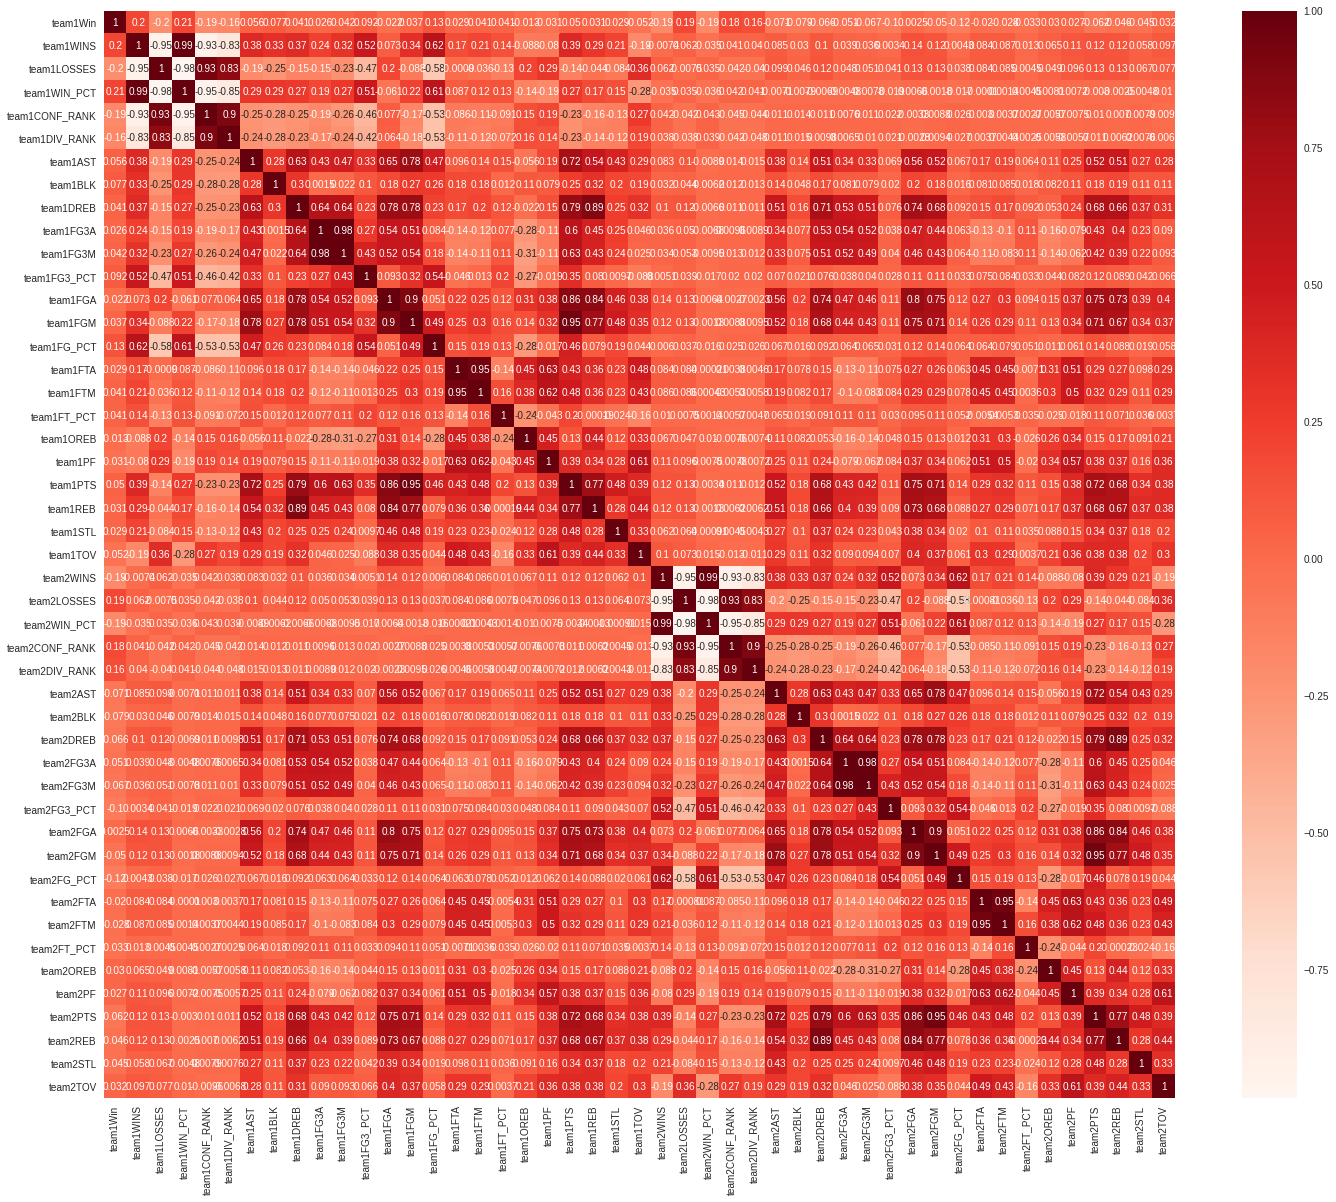

In [ ]:
plt.figure(figsize=(24,20))
cor = mergedSeasonDfs.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Due to the number of features in the dataset, there are an enormous number of correlation values. However, we can immediately notice some correlated features and trends that stand out.

For each team, win percentage is strongly correlated with wins and losses, which is obvious given the direct relationship between the features. Thus, we can drop wins and losses from our dataset. Additionally, we see strong relationships between a team's conference and division rankings and the number of wins and losses that team has. Again, this relationship makes sense, as a team with more wins and fewer losses will rise to the top of the conference and division rankings. Conversely, teams with more losses and fewer wins will be at the bottom of the rankings. Thus, since we are keeping win percentage in our dataset, conference and division rankings can be dropped as well. 

Now, let's take a look at more "basketball-oriented" statistics. For example, we see that there are strong (again, in hindsight obvious) strong positive correlations between features such as free-throws attempted and free-throws made, and field goals attempted and field goals made. We will drop all "attempts" related features and keep all "made" related features. Moreover, we will keep all "percentage" related features, such as 3-point percentage. We see that this feature is not strongly correlated with 3-pointers made or 3-pointers attempted. This is because even if a team makes many 3-pointers, their percentage is not necessarily high. By holding on to "made" and "percentage" features, we capture the essence of a team's shooting performance.

Let's drop the aforementioned features and revisit the correlation matrix. 

In [ ]:
mergedSeasonDfs = mergedSeasonDfs.drop(columns=['team1WINS', 'team1LOSSES', 'team1CONF_RANK', 'team1DIV_RANK', 'team1FG3A', 'team1FGA', 'team1FTA'])
mergedSeasonDfs = mergedSeasonDfs.drop(columns=['team2WINS', 'team2LOSSES', 'team2CONF_RANK', 'team2DIV_RANK', 'team2FG3A', 'team2FGA', 'team2FTA'])

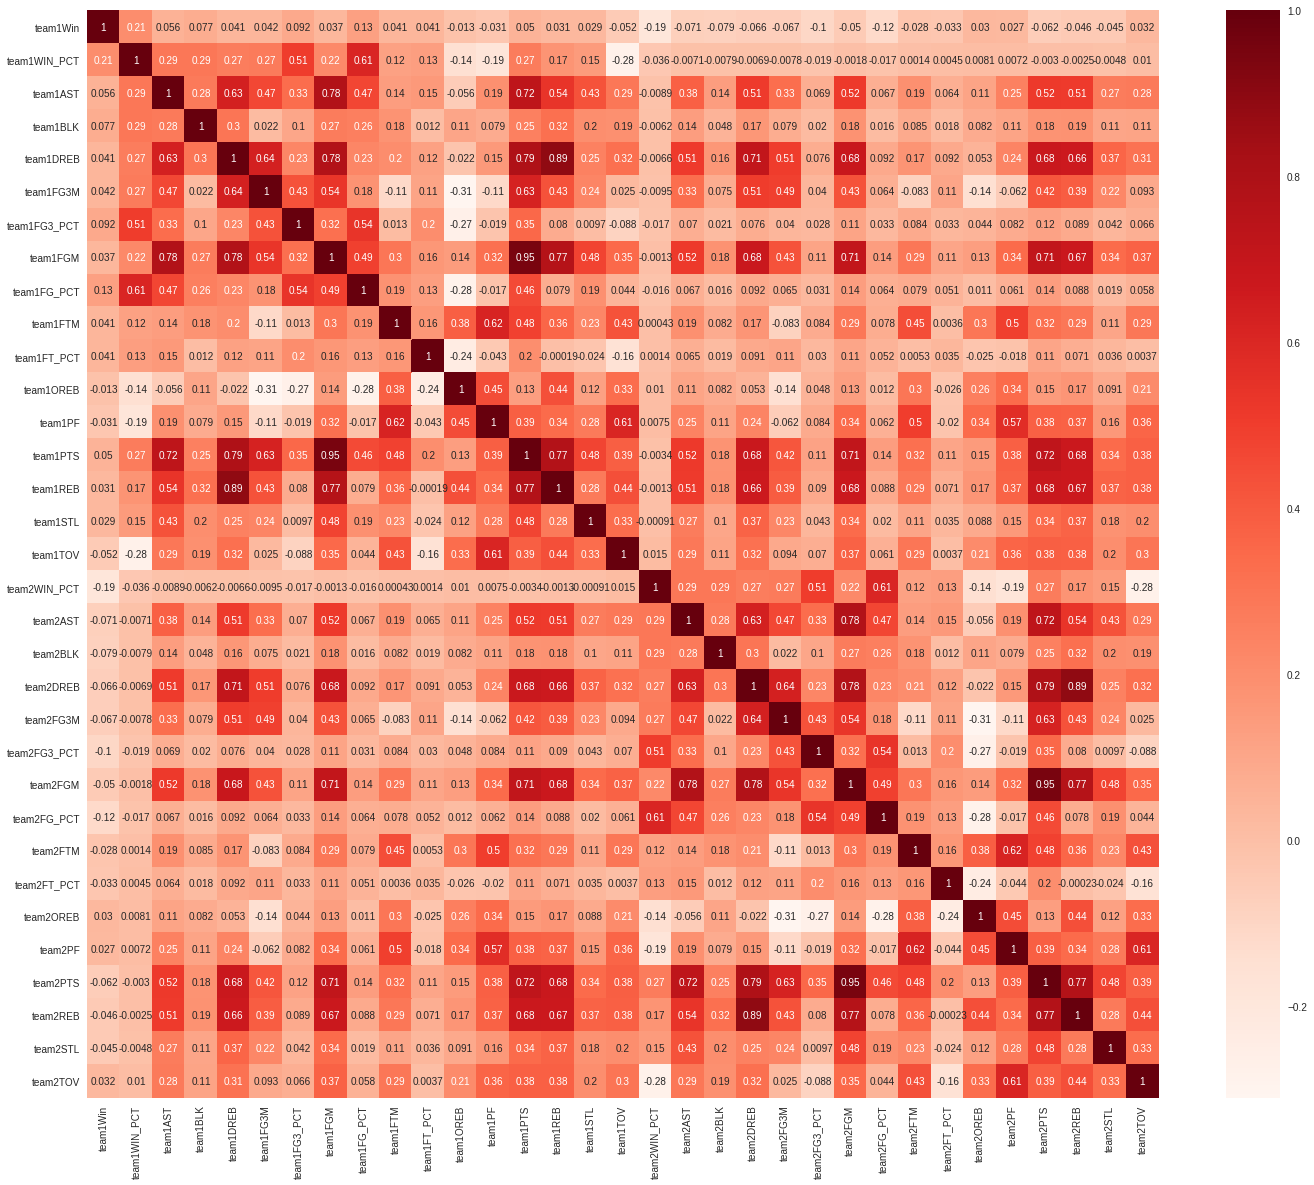

In [ ]:
plt.figure(figsize=(24,20))
cor = mergedSeasonDfs.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Looking at the data further, we can make some more decisions on features to keep or drop to avoid multicollinearity based on background domain knowledge and correlations. For example, we see that field goals made are strongly correlated to points. Thus, field goals made can be dropped. 

We also see some fascinating correlations between assists and points, and between defensive rebounds and points. Namely, the more assists a team has, the more points they score. Additionally, if a team gets more defensive rebounds in a game, perhaps they get more fast break points, adding to their overall point total. Since these features represent core aspects of a team's identity and performative characteristics, we will not drop them and instead keep them in the model.

Lastly, it is important to look at which features correlate with team1Win: the label for each row. From the matrix, we can see that the features that correlate strongest with team1Win are team 1's win percentage (positive correlation) and team 2's win percentage. Although both correlations hover around 0.2 and -0.2, respectively, these values are significanlty greater than all other feature values. Because we want to avoid our model disproportionately focusing on win percentage in predicting the winner of a game (and to instead look at performative statistics and more closely), we will drop this feature.

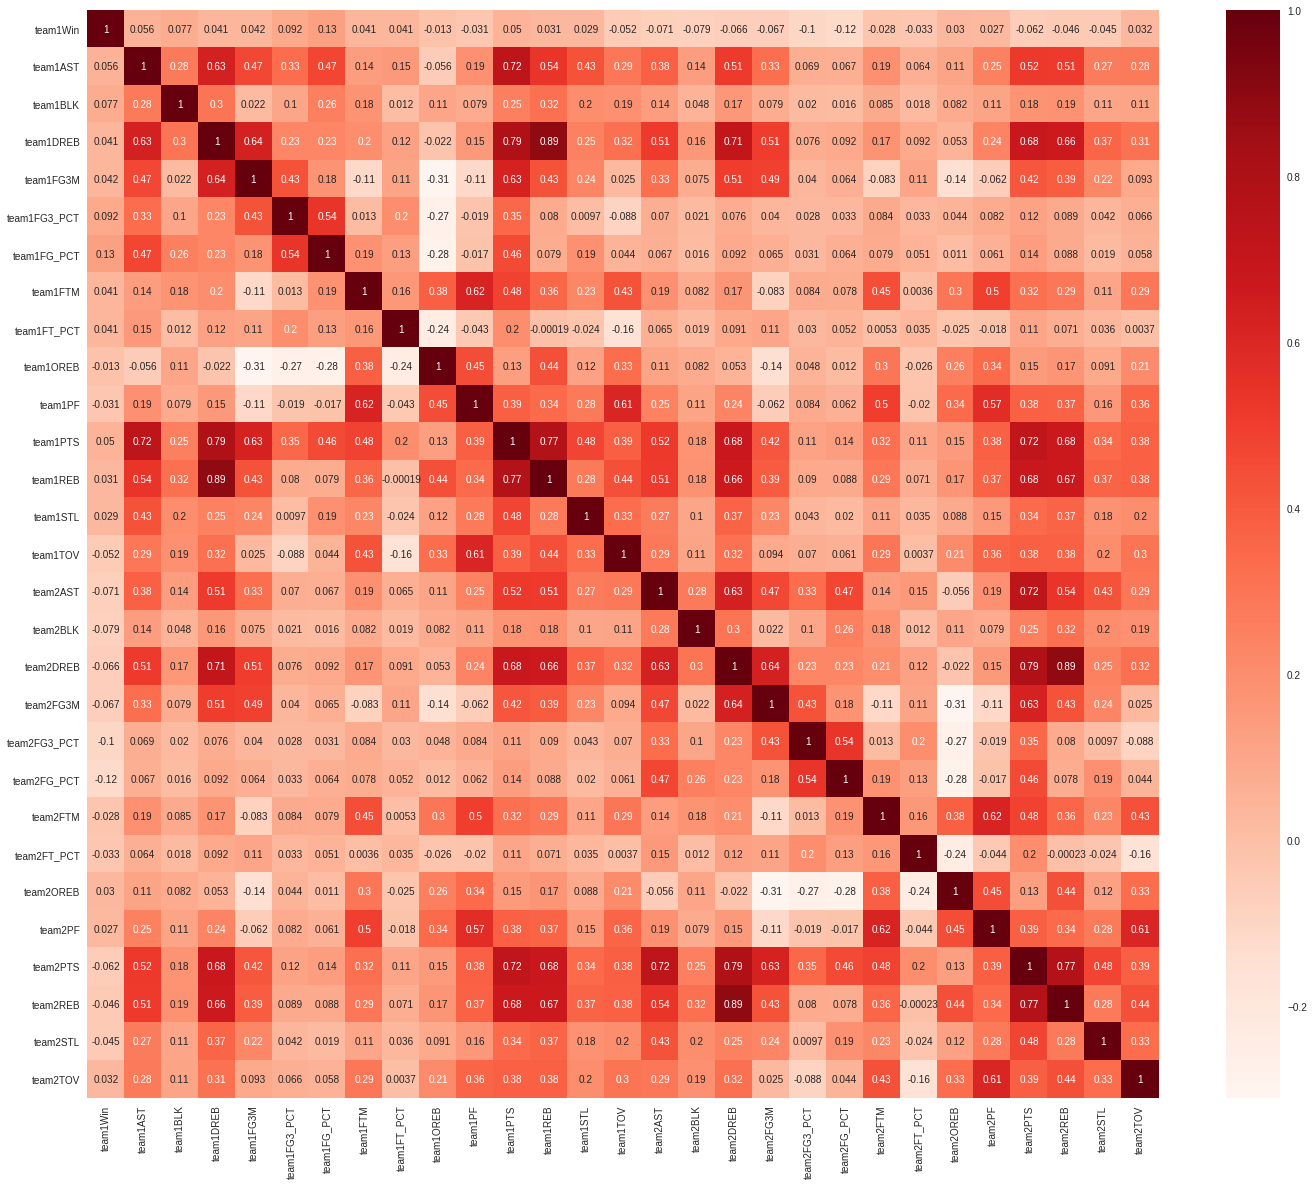

In [ ]:
mergedSeasonDfs = mergedSeasonDfs.drop(columns=['team1WIN_PCT', 'team2WIN_PCT', 'team1FGM', 'team2FGM'])
plt.figure(figsize=(24,20))
cor = mergedSeasonDfs.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Now that we have a better sense of which features we wish to have in our final dataset, let's take a deeper look at how some of the features are distributed. With the number of samples we have, we expect most of the features to be normally distributed.

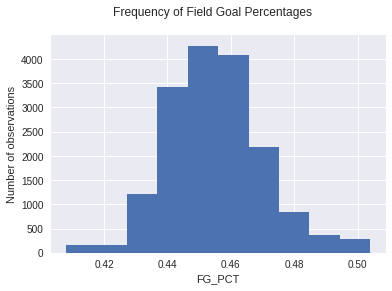

In [ ]:
# frequency of field goal percentages
plt.hist(mergedSeasonDfs['team1FG_PCT'], bins = 10)
plt.xlabel('FG_PCT')
plt.ylabel('Number of observations')
plt.suptitle("Frequency of Field Goal Percentages")
plt.show()

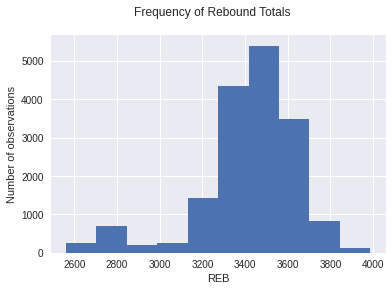

In [ ]:
# frequency of rebounds
plt.hist(mergedSeasonDfs['team1REB'], bins = 10)
plt.xlabel('REB')
plt.ylabel('Number of observations')
plt.suptitle("Frequency of Rebound Totals")
plt.show()

Indeed, we can see that features such as field goal percentage and rebounds follow an approximate normal distribution.

Additionally, to check for outliers for certain features and also get an idea of their importance in predicting the "team1Win" label, let's visualize the distribution of common statistics (blocks, rebound differential, field goal percentage) grouped by "team1Win" via side by side violinplots.

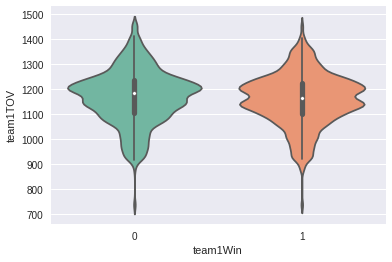

In [ ]:
import seaborn as sn
ax = sn.violinplot(x="team1Win", y="team1TOV", data=mergedSeasonDfs, palette = "Set2")

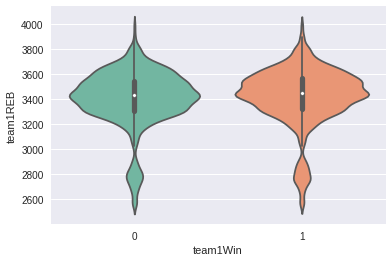

In [ ]:
ax = sn.violinplot(x="team1Win", y="team1REB", data=mergedSeasonDfs, palette = "Set2")

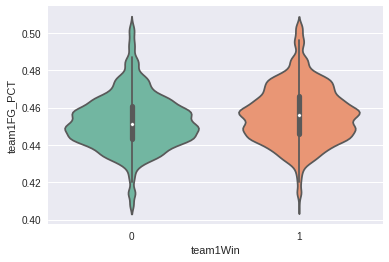

In [ ]:
ax = sn.violinplot(x="team1Win", y="team1FG_PCT", data=mergedSeasonDfs, palette = "Set2")

Of the statistics we've considered, the distribution of "team1FG_PCT" is the most different when looking across "team1Win", indicating that it will be an important feature for predictions. This is confirmed by the high correlation between the two columns evident in the correlation matrix. Through our analysis, we've found that there are no "obvious" characteristics of a team's performance which can lead to a definite prediction of a win or a loss. Thus, it will be important to use machine learning to try and model relationships and make accurate predictions. 

# Modeling

Now that we have our final dataset, we can begin modeling. Before building a model to predict winners of games from the 2019-20 season, though, it is important to establish a baseline value to which we compare our final accuracy. 

We begin by creating a merged DataFrame of the 2019-20 season data and 2018-19 team data that we isolated in the previous data wrangling steps.

In [ ]:
# create merged DataFrame with 2019-20 season data and 2018-19 team data
testSeasonDfs = [testSeasonDf]
testTeamDfs = [testTeamDf]
# creating a merged DataFrame
lastSeasonDfs = pd.DataFrame()
# iterate through season DataFrames
for i in range(len(testSeasonDfs)):
  mergedSeasonDf = pd.DataFrame()
  # iterate through each row (each game)
  for index, row in testSeasonDfs[i].iterrows():
    # store whether or not the home team won in a variable
    team1Win = row['HOME_TEAM_WIN']
    # store information for the IDs of the home and away teams
    team1Id = row['HOME_TEAM_ID']
    team2Id = row['AWAY_TEAM_ID']
    # reference teams DataFrame for the previous season
    teamDf = testTeamDfs[i]
    # record team 1's statistics
    team1stats = teamDf[teamDf['TEAM_ID'] == team1Id]
    team1stats = team1stats.to_dict('records')
    team1stats = team1stats[0]
    team1WIN_PCT = team1stats['WIN_PCT']
    team1AST = team1stats['AST']
    team1BLK = team1stats['BLK']
    team1DREB = team1stats['DREB']
    team1FG3M = team1stats['FG3M']
    team1FG3_PCT = team1stats['FG3_PCT']
    team1FG_PCT = team1stats['FG_PCT']
    team1FTM = team1stats['FTM']
    team1FT_PCT = team1stats['FT_PCT']
    team1OREB = team1stats['OREB']
    team1PF = team1stats['PF']
    team1PTS = team1stats['PTS']
    team1REB = team1stats['REB']
    team1STL = team1stats['STL']
    team1TOV = team1stats['TOV']
    # record team 2's statistics
    team2stats = teamDf[teamDf['TEAM_ID'] == team2Id]
    team2stats = team2stats.to_dict('records')
    team2stats = team2stats[0]
    team2WIN_PCT = team2stats['WIN_PCT']
    team2AST = team2stats['AST']
    team2BLK = team2stats['BLK']
    team2DREB = team2stats['DREB']
    team2FG3M = team2stats['FG3M']
    team2FG3_PCT = team2stats['FG3_PCT']
    team2FG_PCT = team2stats['FG_PCT']
    team2FTM = team2stats['FTM']
    team2FT_PCT = team2stats['FT_PCT']
    team2OREB = team2stats['OREB']
    team2PF = team2stats['PF']
    team2PTS = team2stats['PTS']
    team2REB = team2stats['REB']
    team2STL = team2stats['STL']
    team2TOV = team2stats['TOV']
    # create a row for overall game stats
    gameStats = pd.DataFrame({'team1Win': team1Win, 'team1WIN_PCT': team1WIN_PCT, 'team1AST': team1AST, 'team1BLK': team1BLK, 'team1DREB': team1DREB,'team1FG3M': team1FG3M, 'team1FG3_PCT': team1FG3_PCT, 'team1FG_PCT': team1FG_PCT, 'team1FTM': team1FTM, 'team1FT_PCT': team1FT_PCT, 'team1OREB': team1OREB, 'team1PF': team1PF, 'team1PTS': team1PTS, 'team1REB': team1REB, 'team1STL': team1STL, 'team1TOV': team1TOV, 'team2WIN_PCT': team2WIN_PCT, 'team2AST': team2AST, 'team2BLK': team2BLK, 'team2DREB': team2DREB, 'team2FG3M': team2FG3M, 'team2FG3_PCT': team2FG3_PCT, 'team2FG_PCT': team2FG_PCT, 'team2FTM': team2FTM, 'team2FT_PCT': team2FT_PCT, 'team2OREB': team2OREB, 'team2PF': team2PF, 'team2PTS': team2PTS, 'team2REB': team2REB, 'team2STL': team2STL, 'team2TOV': team2TOV}, index=[0])
    mergedSeasonDf = pd.concat([mergedSeasonDf, gameStats])
  lastSeasonDfs = pd.concat([lastSeasonDfs, mergedSeasonDf])

To establish a baseline estimate, we would like to construct as simple a model as possible for predicting the winners of a game. One of the simplest ways to predict the winner between two teams is to pick the team that had a higher win percentage in the previous season. Thus, for the baseline model, we will drop all features except for team1 win percentage and team2 win percentage

In [ ]:
# create a new baseline DataFrame with only win percentage features
lastSeasonBaselineDfs = lastSeasonDfs[['team1Win', 'team1WIN_PCT', 'team2WIN_PCT']]

Now, we will create a new column which "predicts" a winner solely based on which team had a higher win percentage. We apply this transformation to the DataFrame by applying a function across every row. 

In [ ]:
# function which predicts a winner based on which team had a higher win percentage in the previous season
def predictBaseline(x):
  if x.team1WIN_PCT >= x.team2WIN_PCT:
    return 1
  else:
    return 0

In [ ]:
# apply the function to the baseline DataFrame
lastSeasonBaselineDfs['predictedTeam1Win'] = lastSeasonBaselineDfs.apply(predictBaseline, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's take a look at the baseline DataFrame

In [ ]:
lastSeasonBaselineDfs

,team1Win,team1WIN_PCT,team2WIN_PCT,predictedTeam1Win
0,0,0.646,0.622,1
0,1,0.585,0.476,1
0,1,0.585,0.598,0
0,1,0.707,0.659,1
0,0,0.512,0.646,0
...,...,...,...,...
0,0,0.512,0.439,1
0,1,0.610,0.598,1
0,1,0.476,0.402,1
0,1,0.707,0.402,1


To obtain an accuracy estimate of this baseline model, we simply calculate the percentage of rows for which predictedTeam1Win equals team1Win.

In [ ]:
# calculate number of rows which correctly predict a team1 loss
correctLoss = len(lastSeasonBaselineDfs[(lastSeasonBaselineDfs['team1Win']==0) & (lastSeasonBaselineDfs['predictedTeam1Win']==0)])
# calculate number of rows which correctly predict a team1 win
correctWin = len(lastSeasonBaselineDfs[(lastSeasonBaselineDfs['team1Win']==1) & (lastSeasonBaselineDfs['predictedTeam1Win']==1)])
# calculate total number of correct predictions
totalCorrectPredictions = correctLoss + correctWin
# store total number of games played
totalGames = len(lastSeasonBaselineDfs)
# divide number of correct predictions by total number of games played
baselineAccuracy = float(totalCorrectPredictions)/float(totalGames) * 100
print("The accuracy of the baseline model is " + str(round(baselineAccuracy, 2)) + "%.")

The accuracy of the baseline model is 59.11%.


As we can see, a baseline model which predicts the winners of games from the 2019-20 season based on teams' win percentages from the previous season results in a 59% accuracy over all the games played. Now, we will build a machine learning model incorporating all the features from our final cleaned data set and evaluate the model's performance against the baseline model. 

The first step of building the model is to separate the dataset into labels (the y values) and features (the X values).

In [ ]:
# create labels array
labels = mergedSeasonDfs['team1Win']
labels = labels.to_numpy()
# create features array (all columns except team1Win labels column)
features = mergedSeasonDfs.drop(columns=['team1Win'])
features = features.to_numpy()

We also want to separate our dataset for the most recent season

In [ ]:
# create labels array
labelsLast = lastSeasonDfs['team1Win']
labelsLast = labelsLast.to_numpy()
# create features array (all columns except team1Win labels column)
featuresLast = lastSeasonDfs.drop(columns=['team1Win', 'team1WIN_PCT', 'team2WIN_PCT'])
featuresLast = featuresLast.to_numpy()

Since our goal is to predict a binary variable (win/loss), we will build different classifiers and observe which classifier model results in the highest prediction accuracy. 

For building our models, we will use SciKit-Learn's library of various classifiers. 

In doing so, we will set up a pipeline to scale our features and apply different machine learning algorithms.

The first classifier we will build is a support vector classifier. We chose to try an SVC because the SVC utilizes kernels to transform the data into a higher-dimensional space and learn a classifier. 

In [ ]:
# Support Vector Classifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# split data
X_train, X_test, y_train, y_test = train_test_split(features, labels)
# scale features
scaler = preprocessing.StandardScaler().fit(X_train)
# set up pipeline
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('svc', SVC())])
# train model
pipe.fit(X_train, y_train)
# get accuracy
accuracySVM = pipe.score(X_test, y_test) * 100.0
print('The testing accuracy of the SVC is ' + str(round(accuracySVM, 2)) + '%')
lastAccuracySVM = pipe.score(featuresLast, labelsLast) * 100.0
print('The accuracy of the SVC on predicting 2019-20 games is ' + str(round(lastAccuracySVM, 2)) + '%')

The testing accuracy of the SVC is 64.22%
The accuracy of the SVC on predicting 2019-20 games is 55.43%


The SVC produced an accuracy of 64% on the test set, but only 55% on the 2019-20 data, which was lower than the baseline.



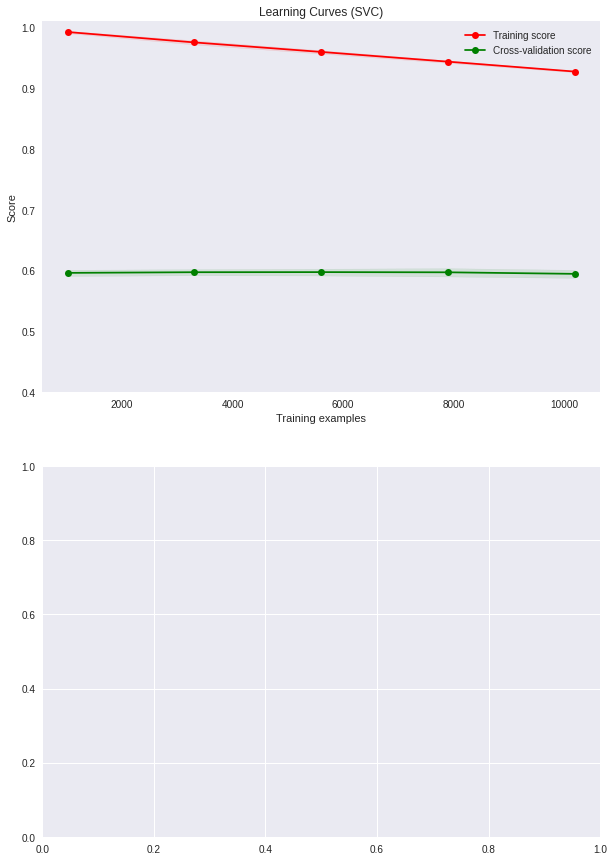

In [ ]:
# note: this code to plot the learning curves was taken from SciKit Learn's website.
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt


fig, axes = plt.subplots(2, 1, figsize=(10, 15))

X, y = X_train, y_train

title = r"Learning Curves (SVC)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:], ylim=(0.4, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

The learning curve above shows a gap between training and cross validation accuracy, indicating high variance.

The next classifier we would like to try is a random forest classifier, which theoretically should reduce the problem of overfitting which may have plagued the SVC model. 

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# split data
X_train, X_test, y_train, y_test = train_test_split(features, labels)
# scale data
scaler = preprocessing.StandardScaler().fit(X_train)
# set up pipeline
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('rf', RandomForestClassifier(random_state=0))])
# train model
pipe.fit(X_train, y_train)
# get accuracy
pipe.score(X_test, y_test)
accuracyRf = pipe.score(X_test, y_test) * 100.0
print('The testing accuracy of the Random Forest Classifier is ' + str(round(accuracyRf, 2)) + '%')
lastAccuracyRf = pipe.score(featuresLast, labelsLast) * 100.0
print('The accuracy of the Random Forest Classifier on predicting 2019-20 games is ' + str(round(lastAccuracyRf, 2)) + '%')

The testing accuracy of the Random Forest Classifier is 62.12%
The accuracy of the Random Forest Classifier on predicting 2019-20 games is 55.15%


The Random Forest Classifier produced an accuracy of 62% on the test set, but only 55% on the 2019-20 data, which was lower than the baseline, indicating that the classifier did not help reduce overfitting problems.

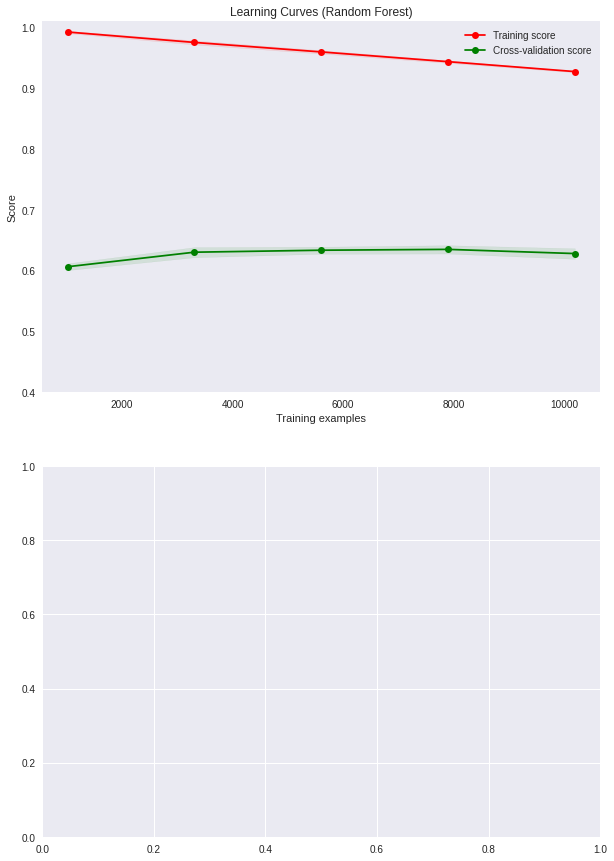

In [ ]:
# note: this code to plot the learning curves was taken from SciKit Learn's website. 
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt


fig, axes = plt.subplots(2, 1, figsize=(10, 15))

X, y = X_train, y_train

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(random_state=0)
plot_learning_curve(estimator, title, X, y, axes=axes[:], ylim=(0.4, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

The learning curve above shows a gap between training and cross validation accuracy, indicating high variance.

Lastly, we will introduce a logistic regression model. The "simplest" of the three models, we are interested to see if logistic regression using L2 regularization can produce a more accurate classifier.

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# split data
X_train, X_test, y_train, y_test = train_test_split(features, labels)
# scale data
scaler = preprocessing.StandardScaler().fit(X_train)
# set up pipeline
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('logreg', LogisticRegression(max_iter=10000))])
# train dta
pipe.fit(X_train, y_train)
# get accuracy 
pipe.score(X_test, y_test)
accuracyLog = pipe.score(X_test, y_test) * 100.0
print('The testing accuracy of the Logistic Regression Classifier is ' + str(round(accuracyLog, 2)) + '%')
lastAccuracyLog = pipe.score(featuresLast, labelsLast) * 100.0
print('The accuracy of the Random Forest Classifier on predicting 2019-20 games is ' + str(round(lastAccuracyLog, 2)) + '%')

The testing accuracy of the Logistic Regression Classifier is 62.83%
The accuracy of the Random Forest Classifier on predicting 2019-20 games is 59.4%


The Logistic Regression Classifier produced an accuracy of 64% on the test set, but 59% on the 2019-20 data, which was about equivalent to the baseline. Overall, this classifier seemed to overfit less than SVC and Random Forest classifiers, leading to a slightly higher accuracy. 

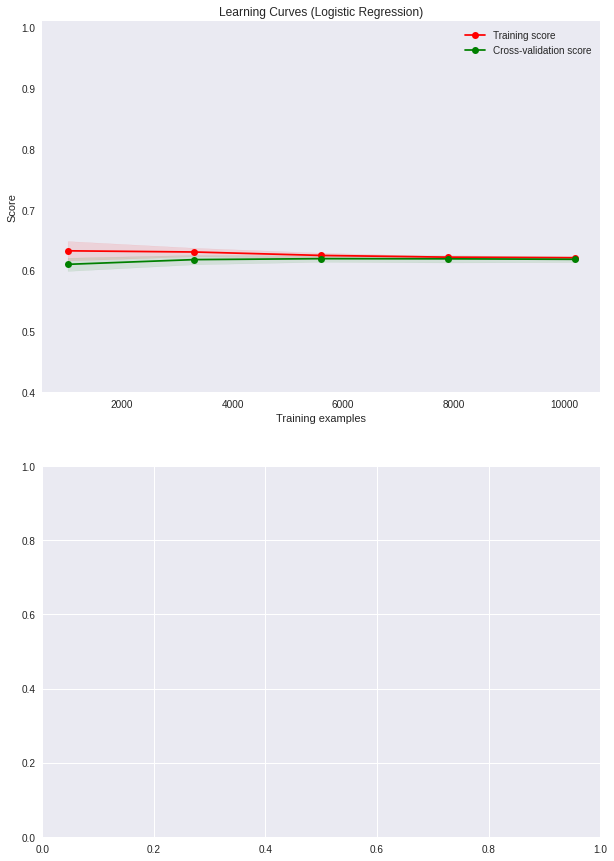

In [ ]:
# note: this code to plot the learning curves was taken from SciKit Learn's website. 
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt


fig, axes = plt.subplots(2, 1, figsize=(10, 15))

X, y = X_train, y_train


title = r"Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LogisticRegression(max_iter=10000)
plot_learning_curve(estimator, title, X, y, axes=axes[:], ylim=(0.4, 1.01),
                    cv=cv, n_jobs=4)


plt.show()

The learning curve above shows alignment between training and cross validation accuracy. However, as overall accuracy is still relatively low, the model suffers from bias.

From looking at the results of the above three models, we observe that logistic regression performed the highest on the 2019-20 sesaon data. Logistic regression may have performed better than the SVC and random forest because it overfit the data less than the other two models, and was thus able to generalize slightly better than those models. However, the overall performance of the model only tied the baseline. 

# Challenges and Obstacles

There were various challenges and obstacles our team faced during this analysis (as also detailed throughout the Data Extraction and Wrangling through Cleaning sections. First, the raw data provided from the NBA required many transformations. For the seasonal game data, we had to parse the dataset to identify the home and away teams, and we had to implement a one-hot encoding to designate the winner of each game. Additionally, since each game appeared twice (contained two rows in each DataFrame), we needed to implement a function to remove duplicates. 

For the team data, our main challenges revolved around identifying the most important features to keep for our machine learning models. To solve this obstacle we created a correlation plot to try and identify any features which could be dropped or were unnecessary to analyze. 

Next, we faced the challenge of merging seasonal data with team data. We could not simply join the two datasets because we needed to add the data for both teams to the same row. A join would have duplicated the seasonal game rows, resulting in a row corresponding to each team and the team's data. Thus, we had to implement a unique function to iterate through all the seasonal game rows and create new columns for the team features we wanted to add.

While building our machine learning models, tuning the various hyperparameters presented a challenge, as both grid searching and randomized searching took extremely long and did not produce significantly improved results in comparision to using the default hyperparameters values for SciKit-Learn. Thus, we kept the default hyperparamter values. In the future, we would like to spend more time tuning hyperparameters and measuring any improved performance to the models we tried. 

# Conclusion

In conclusion, considering a team's statistical performance from the previous season does not lead to significant improvements in predicting the winners of NBA games. 

While all SVC, Logistic Regression, and Random Forest Classifier models showed an improved accuracy on the test sets compared to our baseline accuracy of ~59%, when predicting games on the 2019-20 NBA season, the best performing classifier was not able to outperform the baseline estimate. We believe there are a few explanations for this result.

First, the 2019-20 NBA season saw a tremendous amount of player movement in the off-season. Superstar players like Anthony Davis, Kawhi Leonard, and Jimmy Butler joined teams whichs struggled in the previous season. Others, like Kevin Durant and Kyrie Irving, departed from teams that had success in the previous year. Additionally, many teams faced injuries and suffered in performance admist the pandemic, like the historically dominant Golden State Warriors.

Again, it's worthy to note that all the machine learning models showed an accuracy of above 60% on the test set. However, even this improved accuracy is not much better than predicting the winner of an NBA game at random, or picking a winner just by looking at a team's record. 

In the future, we would like to consider the impact of individual players on predicting the outcome of a game, rather than a team's historical performance. Because players move from team to team, and superstar players can have tremendous influence on how a team performs, it would be interesting to consider how a player's statistics could be used to predict NBA game winners.

Another future topic of exploration would be to input real-time, more recent statistics into our models to see if recent team data is a better predictor of a team's success. Instead of using team data from the previous season, looking at how a team performed in the past five games, for instance, may lead to more accurate predictions of whether a team will win. 

Thus, one can conlude that if an individual hopes to predict the winner of an NBA game, looking at a team's historical performance can marginally help - but only under restricted circumstances.

# References

[1] https://www.espn.com/chalk/story/_/id/29174799/sports-betting-growth-us-extraordinary
[2] https://www.yogonet.com/international/noticias/2020/06/24/53713-global-sports-betting-market-expected-to-reach-nearly-15549-b-by-2024
[3]  https://www.theringer.com/nba/2019/6/27/18760309/nba-title-windows
[4]https://github.com/swar/nba_api





